# Method 9 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

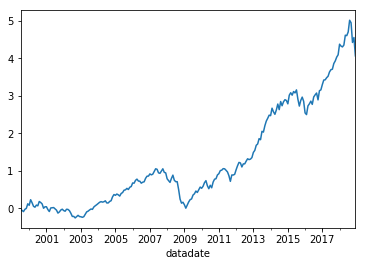

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.124196
2000-12-31   -0.070944
2001-12-31   -0.061119
2002-12-31   -0.200130
2003-12-31    0.403001
2004-12-31    0.245498
2005-12-31    0.156540
2006-12-31    0.175541
2007-12-31    0.046375
2008-12-31   -0.401907
2009-12-31    0.346828
2010-12-31    0.205884
2011-12-31    0.008716
2012-12-31    0.233895
2013-12-31    0.479985
2014-12-31    0.111962
2015-12-31   -0.005391
2016-12-31    0.078797
2017-12-31    0.225024
2018-12-31   -0.005855
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     585.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.52e-119
Time:                        20:58:34   Log-Likelihood:                 673.56
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     229   BIC:                            -1320.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.418      0.001       0.001       0.005
mktrf          0.8904      0.026     34.717      0.000       0.840       0.941
me             0.3558      0.030     11.928      0.000       0.297       0.415
ia            -0.1605      0.045     -3.540      0.000      -0.250      -0.071
roe            0.0494      0.039      1.273      0.204      -0.027       0.126
==============================================================================
Omnibus:                       30.696   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.766
Skew:                          -0.655   Prob(JB):                     2.35e-14
Kurtosis:                       5.173   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     458.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.37e-108
Time:                        20:58:34   Log-Likelihood:                 673.56
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     229   BIC:                            -1320.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.394      0.001       0.001       0.005
mktrf          0.8904      0.037     23.834      0.000       0.817       0.964
me             0.3558      0.043      8.185      0.000       0.271       0.441
ia            -0.1605      0.068     -2.351      0.019      -0.294      -0.027
roe            0.0494      0.061      0.809      0.418      -0.070       0.169
==============================================================================
Omnibus:                       30.696   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.766
Skew:                          -0.655   Prob(JB):                     2.35e-14
Kurtosis:                       5.173   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     573.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.56e-118
Time:                        20:58:34   Log-Likelihood:                 673.56
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     229   BIC:                            -1320.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.943      0.003       0.001       0.005
mktrf          0.8904      0.029     30.555      0.000       0.833       0.948
me             0.3558      0.043      8.323      0.000       0.272       0.440
ia            -0.1605      0.064     -2.516      0.012      -0.286      -0.035
roe            0.0494      0.054      0.907      0.364      -0.057       0.156
==============================================================================
Omnibus:                       30.696   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.766
Skew:                          -0.655   Prob(JB):                     2.35e-14
Kurtosis:                       5.173   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     440.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.89e-115
Time:                        20:58:34   Log-Likelihood:                 667.37
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.809      0.000       0.002       0.006
mktrf          0.8753      0.026     33.099      0.000       0.823       0.927
smb            0.3263      0.035      9.351      0.000       0.258       0.395
hml           -0.0773      0.041     -1.878      0.062      -0.158       0.004
rmw           -0.0692      0.047     -1.488      0.138      -0.161       0.022
cma            0.0051      0.059      0.086      0.932      -0.111       0.122
==============================================================================
Omnibus:                       22.076   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.187
Skew:                          -0.511   Prob(JB):                     1.88e-09
Kurtosis:                       4.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     489.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.03e-120
Time:                        20:58:34   Log-Likelihood:                 667.37
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.609      0.000       0.002       0.006
mktrf          0.8753      0.038     23.108      0.000       0.801       0.950
smb            0.3263      0.045      7.276      0.000       0.238       0.414
hml           -0.0773      0.055     -1.402      0.161      -0.185       0.031
rmw           -0.0692      0.067     -1.038      0.299      -0.200       0.062
cma            0.0051      0.127      0.040      0.968      -0.243       0.253
==============================================================================
Omnibus:                       22.076   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.187
Skew:                          -0.511   Prob(JB):                     1.88e-09
Kurtosis:                       4.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     586.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.10e-128
Time:                        20:58:34   Log-Likelihood:                 667.37
No. Observations:                 234   AIC:                            -1323.
Df Residuals:                     228   BIC:                            -1302.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.175      0.001       0.001       0.006
mktrf          0.8753      0.035     24.918      0.000       0.806       0.944
smb            0.3263      0.042      7.773      0.000       0.244       0.409
hml           -0.0773      0.058     -1.325      0.185      -0.192       0.037
rmw           -0.0692      0.064     -1.090      0.276      -0.194       0.055
cma            0.0051      0.141      0.036      0.971      -0.271       0.281
==============================================================================
Omnibus:                       22.076   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.187
Skew:                          -0.511   Prob(JB):                     1.88e-09
Kurtosis:                       4.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     602.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.00e-120
Time:                        20:58:34   Log-Likelihood:                 676.54
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.078      0.002       0.001       0.005
mktrf          0.9473      0.023     40.632      0.000       0.901       0.993
smb            0.2923      0.029     10.045      0.000       0.235       0.350
hml           -0.0093      0.029     -0.321      0.749      -0.066       0.048
umd            0.1014      0.019      5.345      0.000       0.064       0.139
==============================================================================
Omnibus:                       32.878   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.656
Skew:                          -0.656   Prob(JB):                     3.73e-17
Kurtosis:                       5.457   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     797.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.84e-133
Time:                        20:58:34   Log-Likelihood:                 676.54
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.885      0.004       0.001       0.005
mktrf          0.9473      0.031     31.048      0.000       0.888       1.007
smb            0.2923      0.043      6.844      0.000       0.209       0.376
hml           -0.0093      0.038     -0.245      0.807      -0.084       0.065
umd            0.1014      0.021      4.799      0.000       0.060       0.143
==============================================================================
Omnibus:                       32.878   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.656
Skew:                          -0.656   Prob(JB):                     3.73e-17
Kurtosis:                       5.457   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     785.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.03e-132
Time:                        20:58:34   Log-Likelihood:                 676.54
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.708      0.007       0.001       0.005
mktrf          0.9473      0.028     34.440      0.000       0.893       1.001
smb            0.2923      0.035      8.430      0.000       0.224       0.360
hml           -0.0093      0.038     -0.247      0.805      -0.083       0.064
umd            0.1014      0.019      5.304      0.000       0.064       0.139
==============================================================================
Omnibus:                       32.878   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.656
Skew:                          -0.656   Prob(JB):                     3.73e-17
Kurtosis:                       5.457   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     262.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.25e-57
Time:                        20:58:34   Log-Likelihood:                 325.97
No. Observations:                 120   AIC:                            -641.9
Df Residuals:                     115   BIC:                            -628.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.357      0.177      -0.001       0.005
mktrf          0.9175      0.042     21.783      0.000       0.834       1.001
me             0.3780      0.042      9.087      0.000       0.296       0.460
ia            -0.1419      0.065     -2.178      0.031      -0.271      -0.013
roe            0.1151      0.058      1.997      0.048       0.001       0.229
==============================================================================
Omnibus:                       14.323   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.533
Skew:                          -0.585   Prob(JB):                     2.11e-05
Kurtosis:                       4.714   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     288.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.72e-59
Time:                        20:58:34   Log-Likelihood:                 325.97
No. Observations:                 120   AIC:                            -641.9
Df Residuals:                     115   BIC:                            -628.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.603      0.109      -0.000       0.005
mktrf          0.9175      0.062     14.893      0.000       0.797       1.038
me             0.3780      0.057      6.658      0.000       0.267       0.489
ia            -0.1419      0.079     -1.785      0.074      -0.298       0.014
roe            0.1151      0.078      1.480      0.139      -0.037       0.268
==============================================================================
Omnibus:                       14.323   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.533
Skew:                          -0.585   Prob(JB):                     2.11e-05
Kurtosis:                       4.714   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     493.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-71
Time:                        20:58:34   Log-Likelihood:                 325.97
No. Observations:                 120   AIC:                            -641.9
Df Residuals:                     115   BIC:                            -628.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.002      1.383      0.167      -0.001       0.005
mktrf          0.9175      0.043     21.106      0.000       0.832       1.003
me             0.3780      0.055      6.903      0.000       0.271       0.485
ia            -0.1419      0.072     -1.976      0.048      -0.283      -0.001
roe            0.1151      0.060      1.915      0.056      -0.003       0.233
==============================================================================
Omnibus:                       14.323   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.533
Skew:                          -0.585   Prob(JB):                     2.11e-05
Kurtosis:                       4.714   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     180.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-52
Time:                        20:58:34   Log-Likelihood:                 318.46
No. Observations:                 120   AIC:                            -624.9
Df Residuals:                     114   BIC:                            -608.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.174      0.032       0.000       0.007
mktrf          0.8827      0.047     18.588      0.000       0.789       0.977
smb            0.3328      0.054      6.187      0.000       0.226       0.439
hml           -0.0879      0.066     -1.334      0.185      -0.219       0.043
rmw           -0.0508      0.078     -0.654      0.515      -0.205       0.103
cma            0.0709      0.085      0.832      0.407      -0.098       0.240
==============================================================================
Omnibus:                        6.809   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.565
Skew:                          -0.456   Prob(JB):                       0.0375
Kurtosis:                       3.694   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     207.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-55
Time:                        20:58:34   Log-Likelihood:                 318.46
No. Observations:                 120   AIC:                            -624.9
Df Residuals:                     114   BIC:                            -608.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.191      0.028       0.000       0.007
mktrf          0.8827      0.074     11.885      0.000       0.737       1.028
smb            0.3328      0.064      5.194      0.000       0.207       0.458
hml           -0.0879      0.087     -1.010      0.312      -0.259       0.083
rmw           -0.0508      0.113     -0.449      0.654      -0.273       0.171
cma            0.0709      0.156      0.454      0.650      -0.235       0.377
==============================================================================
Omnibus:                        6.809   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.565
Skew:                          -0.456   Prob(JB):                       0.0375
Kurtosis:                       3.694   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     207.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.79e-55
Time:                        20:58:34   Log-Likelihood:                 318.46
No. Observations:                 120   AIC:                            -624.9
Df Residuals:                     114   BIC:                            -608.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.914      0.056      -9e-05       0.008
mktrf          0.8827      0.069     12.829      0.000       0.748       1.018
smb            0.3328      0.059      5.673      0.000       0.218       0.448
hml           -0.0879      0.093     -0.942      0.346      -0.271       0.095
rmw           -0.0508      0.114     -0.448      0.654      -0.273       0.172
cma            0.0709      0.169      0.418      0.676      -0.261       0.403
==============================================================================
Omnibus:                        6.809   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.565
Skew:                          -0.456   Prob(JB):                       0.0375
Kurtosis:                       3.694   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     259.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-56
Time:                        20:58:34   Log-Likelihood:                 325.39
No. Observations:                 120   AIC:                            -640.8
Df Residuals:                     115   BIC:                            -626.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.151      0.034       0.000       0.006
mktrf          0.9714      0.037     26.053      0.000       0.898       1.045
smb            0.2799      0.042      6.593      0.000       0.196       0.364
hml            0.0117      0.043      0.275      0.784      -0.073       0.096
umd            0.1155      0.026      4.405      0.000       0.064       0.167
==============================================================================
Omnibus:                       21.328   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.033
Skew:                          -0.791   Prob(JB):                     9.08e-09
Kurtosis:                       5.214   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     554.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.98e-74
Time:                        20:58:34   Log-Likelihood:                 325.39
No. Observations:                 120   AIC:                            -640.8
Df Residuals:                     115   BIC:                            -626.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.195      0.028       0.000       0.006
mktrf          0.9714      0.047     20.531      0.000       0.879       1.064
smb            0.2799      0.062      4.505      0.000       0.158       0.402
hml            0.0117      0.047      0.248      0.804      -0.081       0.104
umd            0.1155      0.025      4.700      0.000       0.067       0.164
==============================================================================
Omnibus:                       21.328   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.033
Skew:                          -0.791   Prob(JB):                     9.08e-09
Kurtosis:                       5.214   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     681.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.78e-79
Time:                        20:58:34   Log-Likelihood:                 325.39
No. Observations:                 120   AIC:                            -640.8
Df Residuals:                     115   BIC:                            -626.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.002      2.152      0.031       0.000       0.006
mktrf          0.9714      0.038     25.585      0.000       0.897       1.046
smb            0.2799      0.050      5.616      0.000       0.182       0.378
hml            0.0117      0.046      0.252      0.801      -0.079       0.102
umd            0.1155      0.017      6.627      0.000       0.081       0.150
==============================================================================
Omnibus:                       21.328   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.033
Skew:                          -0.791   Prob(JB):                     9.08e-09
Kurtosis:                       5.214   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     414.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.39e-65
Time:                        20:58:34   Log-Likelihood:                 367.98
No. Observations:                 114   AIC:                            -726.0
Df Residuals:                     109   BIC:                            -712.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      4.537      0.000       0.002       0.006
mktrf          0.8767      0.029     30.399      0.000       0.820       0.934
me             0.3045      0.045      6.839      0.000       0.216       0.393
ia            -0.2720      0.062     -4.404      0.000      -0.394      -0.150
roe           -0.1516      0.054     -2.793      0.006      -0.259      -0.044
==============================================================================
Omnibus:                        1.123   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                0.678
Skew:                          -0.138   Prob(JB):                        0.712
Kurtosis:                       3.257   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     439.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.09e-66
Time:                        20:58:34   Log-Likelihood:                 367.98
No. Observations:                 114   AIC:                            -726.0
Df Residuals:                     109   BIC:                            -712.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.590      0.000       0.002       0.007
mktrf          0.8767      0.026     33.344      0.000       0.825       0.928
me             0.3045      0.041      7.506      0.000       0.225       0.384
ia            -0.2720      0.077     -3.530      0.000      -0.423      -0.121
roe           -0.1516      0.072     -2.098      0.036      -0.293      -0.010
==============================================================================
Omnibus:                        1.123   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                0.678
Skew:                          -0.138   Prob(JB):                        0.712
Kurtosis:                       3.257   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     705.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.48e-77
Time:                        20:58:34   Log-Likelihood:                 367.98
No. Observations:                 114   AIC:                            -726.0
Df Residuals:                     109   BIC:                            -712.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.001      3.062      0.002       0.002       0.007
mktrf          0.8767      0.024     37.057      0.000       0.830       0.923
me             0.3045      0.043      7.046      0.000       0.220       0.389
ia            -0.2720      0.084     -3.249      0.001      -0.436      -0.108
roe           -0.1516      0.071     -2.146      0.032      -0.290      -0.013
==============================================================================
Omnibus:                        1.123   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                0.678
Skew:                          -0.138   Prob(JB):                        0.712
Kurtosis:                       3.257   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     410.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.57e-68
Time:                        20:58:34   Log-Likelihood:                 380.02
No. Observations:                 114   AIC:                            -748.0
Df Residuals:                     108   BIC:                            -731.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.967      0.000       0.002       0.005
mktrf          0.8929      0.025     35.916      0.000       0.844       0.942
smb            0.2849      0.040      7.058      0.000       0.205       0.365
hml           -0.0903      0.051     -1.753      0.082      -0.192       0.012
rmw           -0.2535      0.063     -4.023      0.000      -0.378      -0.129
cma           -0.2063      0.080     -2.578      0.011      -0.365      -0.048
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.240
Skew:                          -0.251   Prob(JB):                        0.538
Kurtosis:                       2.910   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     313.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-62
Time:                        20:58:34   Log-Likelihood:                 380.02
No. Observations:                 114   AIC:                            -748.0
Df Residuals:                     108   BIC:                            -731.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.483      0.000       0.002       0.005
mktrf          0.8929      0.025     35.522      0.000       0.844       0.942
smb            0.2849      0.028     10.300      0.000       0.231       0.339
hml           -0.0903      0.046     -1.975      0.048      -0.180      -0.001
rmw           -0.2535      0.050     -5.040      0.000      -0.352      -0.155
cma           -0.2063      0.090     -2.296      0.022      -0.382      -0.030
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.240
Skew:                          -0.251   Prob(JB):                        0.538
Kurtosis:                       2.910   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     291.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.58e-61
Time:                        20:58:34   Log-Likelihood:                 380.02
No. Observations:                 114   AIC:                            -748.0
Df Residuals:                     108   BIC:                            -731.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.880      0.004       0.001       0.006
mktrf          0.8929      0.026     34.480      0.000       0.842       0.944
smb            0.2849      0.029      9.770      0.000       0.228       0.342
hml           -0.0903      0.038     -2.383      0.017      -0.164      -0.016
rmw           -0.2535      0.052     -4.869      0.000      -0.356      -0.151
cma           -0.2063      0.076     -2.709      0.007      -0.356      -0.057
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.240
Skew:                          -0.251   Prob(JB):                        0.538
Kurtosis:                       2.910   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     418.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.70e-65
Time:                        20:58:34   Log-Likelihood:                 368.55
No. Observations:                 114   AIC:                            -727.1
Df Residuals:                     109   BIC:                            -713.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.570      0.012       0.001       0.004
mktrf          0.9256      0.027     34.037      0.000       0.872       0.979
smb            0.3363      0.042      7.930      0.000       0.252       0.420
hml           -0.0967      0.044     -2.214      0.029      -0.183      -0.010
umd            0.0472      0.033      1.432      0.155      -0.018       0.112
==============================================================================
Omnibus:                        2.636   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.187
Skew:                          -0.330   Prob(JB):                        0.335
Kurtosis:                       3.156   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     654.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.22e-75
Time:                        20:58:34   Log-Likelihood:                 368.55
No. Observations:                 114   AIC:                            -727.1
Df Residuals:                     109   BIC:                            -713.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.295      0.022       0.000       0.005
mktrf          0.9256      0.018     50.888      0.000       0.890       0.961
smb            0.3363      0.038      8.810      0.000       0.261       0.411
hml           -0.0967      0.036     -2.698      0.007      -0.167      -0.026
umd            0.0472      0.034      1.374      0.170      -0.020       0.114
==============================================================================
Omnibus:                        2.636   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.187
Skew:                          -0.330   Prob(JB):                        0.335
Kurtosis:                       3.156   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     853.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-81
Time:                        20:58:34   Log-Likelihood:                 368.55
No. Observations:                 114   AIC:                            -727.1
Df Residuals:                     109   BIC:                            -713.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.003      0.045    5.32e-05       0.005
mktrf          0.9256      0.018     50.895      0.000       0.890       0.961
smb            0.3363      0.043      7.736      0.000       0.251       0.421
hml           -0.0967      0.030     -3.176      0.001      -0.156      -0.037
umd            0.0472      0.037      1.261      0.207      -0.026       0.121
==============================================================================
Omnibus:                        2.636   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.187
Skew:                          -0.330   Prob(JB):                        0.335
Kurtosis:                       3.156   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""